In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import json

In [2]:
output_dir = 'query_results'
os.makedirs(output_dir, exist_ok=True)

In [3]:
file_path = f'./{output_dir}/business_results.json'

phone_business_file_name = 'phone_business.json'
other_business_file_name = 'other_business.json'
total_business_file_name = 'total_business.json'

phone_business_path = f'./{output_dir}/{phone_business_file_name}'
other_business_path = f'./{output_dir}/{other_business_file_name}'
total_business_path = f'./{output_dir}/{total_business_file_name}'

In [4]:
data = pd.read_json(file_path)
df = pd.json_normalize(data['results'])

In [5]:
# 'id' kolonu üzerinden duplicate'leri temizle ve df'yi güncelle
df = df.drop_duplicates(subset=['id'])

# Adreste "istanbul" veya "tekirdağ" geçenleri filtrele (case-insensitive)
df = df[df['address'].str.contains('istanbul|tekirdağ', case=False, na=False)]

# Sonuçları göster
print(f"Orijinal Veri Sayısı: {len(data['results'])}")
print(f"Duplicate'ten ve Filtrelemeden Sonra Veri Sayısı: {len(df)}")

Orijinal Veri Sayısı: 18809
Duplicate'ten ve Filtrelemeden Sonra Veri Sayısı: 18695


In [6]:
# **Detaylı Filtreleme:**
# 1. Sadece telefon olanlar (Website boş)
phone_only = df[df['phone'].notna() & df['website'].isna()]

# 2. Sadece website olanlar (Phone boş)
website_only = df[df['phone'].isna() & df['website'].notna()]

# 3. Hem telefon hem website olanlar
both_filled = df[df['phone'].notna() & df['website'].notna()]

# 4. Hem telefon hem website olmayanlar
neither_filled = df[df['phone'].isna() & df['website'].isna()]

# Detaylı filtreleme sonuçlarının uzunluklarını yazdır
print(f"\nSadece Phone Olan Satır Sayısı: {len(phone_only)}")
print(f"Sadece Website Olan Satır Sayısı: {len(website_only)}")
print(f"Hem Phone Hem Website Olan Satır Sayısı: {len(both_filled)}")
print(f"Hem Phone Hem Website Olmayan Satır Sayısı: {len(neither_filled)}")


Sadece Phone Olan Satır Sayısı: 7325
Sadece Website Olan Satır Sayısı: 532
Hem Phone Hem Website Olan Satır Sayısı: 6558
Hem Phone Hem Website Olmayan Satır Sayısı: 4280


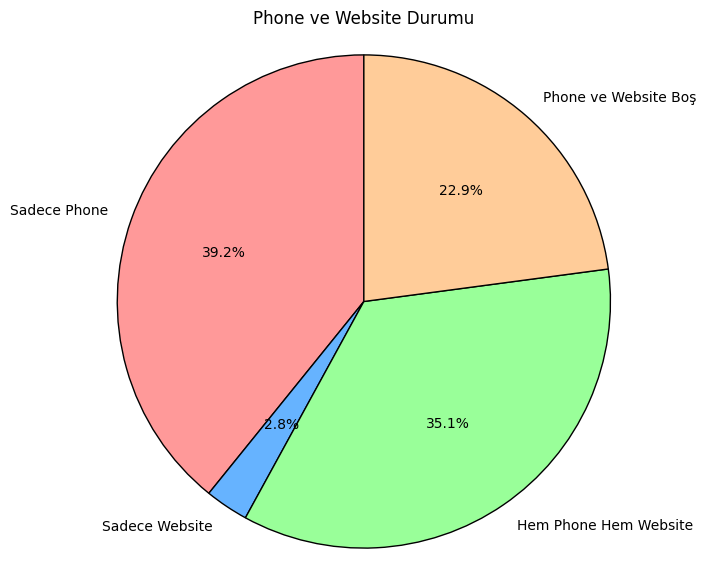

In [7]:
# Pasta Grafiği için Veriler
labels = ['Sadece Phone', 'Sadece Website', 'Hem Phone Hem Website', 'Phone ve Website Boş']
sizes = [len(phone_only), len(website_only), len(both_filled), len(neither_filled)]
colors = ['#ff9999','#66b3ff','#99ff99', '#ffcc99']  # Renkler

# Pasta grafiği oluşturma
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Phone ve Website Durumu')
plt.axis('equal')  # Eşit boyutta daire yapar
plt.show()

In [8]:
total_business_data = pd.concat([phone_only, website_only, both_filled])

print(f"Toplam Etkileşimli Müşteri Sayısı: {len(total_business_data)}")

Toplam Etkileşimli Müşteri Sayısı: 14415


In [9]:
# Telefon numarasını temizleme fonksiyonu
def clean_phone_number(phone):
    if pd.notna(phone):
        # Boşlukları, parantezleri ve + işaretlerini temizle
        cleaned_phone = re.sub(r"[^\d]", "", str(phone))  # Sadece rakamları bırak
        return cleaned_phone
    return phone

# Cep telefonu numaraları için regex deseni
phone_regex = r"^05\d{9}$"  # '05' ile başlayan, 9 haneli numara

# Kategorize etme fonksiyonu
def categorize_phone(phone):
    if pd.notna(phone):
        # Cep telefonu kontrolü
        if re.match(phone_regex, phone):
            return 'Cep Telefonu'
        # Kurumsal numara (genellikle sabit hatlar) kontrolü
        elif not phone.startswith('05'):  # Sabit hatlar genelde 10 hanelidir
            return 'Kurumsal Numara'
    return 'No Phone'

# Veriyi temizle ve telefonları kategorize et
total_business_data['cleaned_phone'] = total_business_data['phone'].apply(clean_phone_number)
total_business_data['phone_category'] = total_business_data['cleaned_phone'].apply(categorize_phone)

# Sonuçları yazdır
cep_telefonu_count = len(total_business_data[total_business_data['phone_category'] == 'Cep Telefonu'])
kurumsal_numara_count = len(total_business_data[total_business_data['phone_category'] == 'Kurumsal Numara'])
no_phone_count = len(total_business_data[total_business_data['phone_category'] == 'No Phone'])

print(f"Cep Telefonu Olan Müşteri Sayısı: {cep_telefonu_count}")
print(f"Kurumsal Numara Olan Müşteri Sayısı: {kurumsal_numara_count}")
print(f"Telefonu Olmayan Müşteri Sayısı: {no_phone_count}")

Cep Telefonu Olan Müşteri Sayısı: 5997
Kurumsal Numara Olan Müşteri Sayısı: 7883
Telefonu Olmayan Müşteri Sayısı: 535


In [10]:
# Tüm veriyi JSON dosyasına kaydet
output_file = os.path.join(output_dir, total_business_file_name)

# Veriyi listeye dönüştür
total_business_data_json = total_business_data[['id', 'name', 'address', 'phone', 'website']].to_dict(orient='records')

# JSON dosyasına yaz
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(total_business_data_json, f, ensure_ascii=False, indent=4)

print(f"Tüm veriler {output_file} dosyasına kaydedildi.")

Tüm veriler query_results/total_business.json dosyasına kaydedildi.


In [11]:
# Cep telefonu olan müşterileri JSON dosyasına kaydet
output_file = os.path.join(output_dir, phone_business_file_name)

# Cep telefonu olan müşterileri filtrele
phone_customers = total_business_data[total_business_data['phone_category'] == 'Cep Telefonu']

# Müşteri verisini listeye dönüştür
phone_customers_data = phone_customers[['id', 'name', 'address', 'phone', 'website']].to_dict(orient='records')

# JSON dosyasına yaz
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(phone_customers_data, f, ensure_ascii=False, indent=4)

print(f"Cep telefonlarına sahip {len(phone_customers)} müşterinin verisi {output_file} dosyasına kaydedildi.")

Cep telefonlarına sahip 5997 müşterinin verisi query_results/phone_business.json dosyasına kaydedildi.


In [12]:
# Diğer iş verilerini JSON dosyasına kaydet
output_file = os.path.join(output_dir, other_business_file_name)

# Kurumsal numaraları ve numarası olmayanları filtrele
# Telefonu olmayanlar veya kurumsal numaralar (telefon numarası "Cep Telefonu" olmayanlar)
other_business = total_business_data[(total_business_data['phone_category'] != 'Cep Telefonu') | total_business_data['phone'].isna()]

# Veriyi listeye dönüştür
other_business_data_json = other_business[['id', 'name', 'address', 'phone', 'website']].to_dict(orient='records')

# JSON dosyasına yaz
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(other_business_data_json, f, ensure_ascii=False, indent=4)

print(f"Kurumsal numaralar ve numara olmayan veriler {output_file} dosyasına kaydedildi.")

Kurumsal numaralar ve numara olmayan veriler query_results/other_business.json dosyasına kaydedildi.


In [13]:
# JSON dosyalarını veri çerçevesine yükle
with open(phone_business_path, 'r', encoding='utf-8') as f:
    phone_business_data = json.load(f)
phone_business_df = pd.DataFrame(phone_business_data)

with open(other_business_path, 'r', encoding='utf-8') as f:
    other_business_data = json.load(f)
other_business_df = pd.DataFrame(other_business_data)

with open(total_business_path, 'r', encoding='utf-8') as f:
    total_business_data = json.load(f)
total_business_df = pd.DataFrame(total_business_data)

# Yineleyen satırları temizle
phone_business_df = phone_business_df.drop_duplicates(subset=['id'])
other_business_df = other_business_df.drop_duplicates(subset=['id'])
total_business_df = total_business_df.drop_duplicates(subset=['id'])

# Karşılaştırma için sadece önemli kolonları seçelim
# Örneğin, 'id' kolonunu karşılaştıracağımız kolon olarak kullanabiliriz
phone_business_df = phone_business_df[['id']]
other_business_df = other_business_df[['id']]
total_business_df = total_business_df[['id']]

# Phone ve Other'dan Gelen Verilerle Total Business Karşılaştırması:
# 1. Phone ve Other'dan gelen verilerle total business'te olup olmayanları bul
phone_other_combined = pd.concat([phone_business_df, other_business_df]).drop_duplicates()

# 2. Total business ile karşılaştır
# Total business'te olup phone veya other'da olmayanları bul
phone_other_only = phone_other_combined[~phone_other_combined['id'].isin(total_business_df['id'])]

# 3. Total business ile eşleşenleri bul
matching_data = total_business_df[total_business_df['id'].isin(phone_other_combined['id'])]

# Sonuçları yazdır
print(f"Phone ve Other'dan Gelen Verilerle Total Business Karşılaştırması:")
print(f"\nPhone ve Other'dan Gelen, Total Business'te Olmayan Sayı: {len(phone_other_only)}")
print(f"Total Business ile Eşleşen Sayı: {len(matching_data)}")

Phone ve Other'dan Gelen Verilerle Total Business Karşılaştırması:

Phone ve Other'dan Gelen, Total Business'te Olmayan Sayı: 0
Total Business ile Eşleşen Sayı: 14415
